In [11]:
"""Run the simulation for a simple two-airport network."""
import os
from itertools import combinations

import click
import matplotlib
import matplotlib.pyplot as plt
import pandas as pd
import pyro
import seaborn as sns
import torch
import tqdm

import bayes_air.utils.dataloader as ba_dataloader
import wandb
from bayes_air.model import air_traffic_network_model
from bayes_air.network import NetworkState
from bayes_air.schedule import parse_schedule

In [12]:
# Load the dataset
top_n = 100
df = pd.read_pickle("../../data/wn_data_clean_cst.pkl")
df = ba_dataloader.top_N_df(df, top_n)
nominal_df, disrupted_df = ba_dataloader.split_nominal_disrupted_data(df)
nominal_dfs = ba_dataloader.split_by_date(nominal_df)
disrupted_dfs = ba_dataloader.split_by_date(disrupted_df)

# Split each disrupted day into 

In [13]:
print(f"# nominal days: {len(nominal_dfs)}")
print(f"# disrupted days: {len(disrupted_dfs)}")
print(f"mean # flights per day (nominal): {[len(d) for d in nominal_dfs]}")
print(f"mean # flights per day (disrupted): {[len(d) for d in disrupted_dfs]}")

# nominal days: 18
# disrupted days: 10
mean # flights per day (nominal): [3617, 3612, 3310, 3878, 3738, 3732, 3732, 3736, 3733, 3348, 3880, 3732, 3732, 3732, 3732, 3879, 3343, 3879]
mean # flights per day (disrupted): [3876, 3876, 3876, 3200, 3552, 3876, 3876, 3876, 3876, 3876]


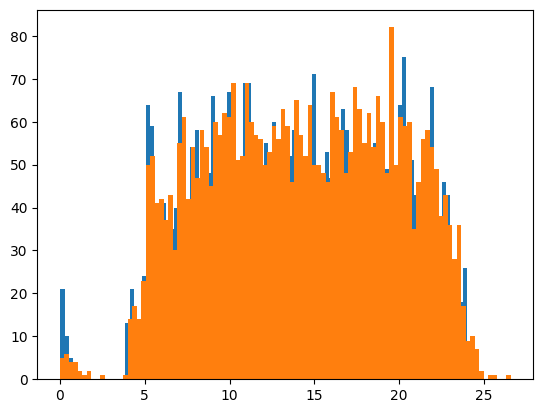

In [14]:
plt.hist(disrupted_dfs[0]["scheduled_departure_time"], bins=100);
plt.hist(nominal_dfs[-1]["actual_departure_time"], bins=100);

In [15]:
# plt.hist(disrupted_dfs[0]["scheduled_departure_time"], bins=100);
disrupted_dfs[0].iloc[:10]

,flight_number,date,origin_airport,destination_airport,scheduled_departure_time,scheduled_arrival_time,actual_departure_time,actual_arrival_time,wheels_on_time,wheels_off_time,cancelled,airport_code_x,origin_time_zone,airport_code_y,destination_time_zone
75354,3376,2022-12-21,PHX,SAN,0.033333,0.616667,0.316667,0.666667,24.216667,0.433333,False,PHX,America/Phoenix,SAN,America/Los_Angeles
16817,1464,2022-12-21,LAS,RNO,0.033333,1.283333,0.350000,1.683333,1.616667,0.550000,False,LAS,America/Los_Angeles,RNO,America/Los_Angeles
5242,4017,2022-12-21,OAK,PHX,0.033333,2.533333,0.350000,2.533333,2.900000,0.500000,False,OAK,America/Los_Angeles,PHX,America/Phoenix
2402,1599,2022-12-21,SEA,OAK,0.033333,2.200000,0.800000,2.733333,2.683333,1.133333,False,SEA,America/Los_Angeles,OAK,America/Los_Angeles
99375,1644,2022-12-21,DEN,SEA,0.066667,2.950000,24.983333,24.983333,24.983333,24.983333,True,DEN,America/Denver,SEA,America/Los_Angeles
43389,737,2022-12-21,DEN,ABQ,0.066667,1.316667,24.983333,24.983333,24.983333,24.983333,True,DEN,America/Denver,ABQ,America/Denver
11623,3265,2022-12-21,DEN,LAS,0.066667,1.866667,24.983333,24.983333,24.983333,24.983333,True,DEN,America/Denver,LAS,America/Los_Angeles
103130,1476,2022-12-21,HNL,ITO,0.083333,1.083333,0.350000,1.316667,1.233333,0.616667,False,HNL,Pacific/Honolulu,ITO,Pacific/Honolulu
4442,3431,2022-12-21,LAS,PHX,0.116667,1.783333,0.850000,2.366667,2.700000,1.033333,False,LAS,America/Los_Angeles,PHX,America/Phoenix
15057,2976,2022-12-21,SJC,LAS,0.116667,1.533333,0.583333,1.883333,1.650000,0.716667,False,SJC,America/Los_Angeles,LAS,America/Los_Angeles


In [16]:
# Get some summary statistics for each day

# Get the travel times for each day
travel_time_dfs = []
for day in tqdm.tqdm(nominal_dfs[-10:] + disrupted_dfs[:5]):
    date = day["date"]
    origin = day["origin_airport"]
    destination = day["destination_airport"]
    travel_times = day["actual_arrival_time"] - day["actual_departure_time"]
    not_cancelled_mask = ~day["cancelled"]
    travel_time_dfs.append(
        pd.DataFrame(
            {
                "date": date[not_cancelled_mask],
                "origin_airport": origin[not_cancelled_mask],
                "destination_airport": destination[not_cancelled_mask],
                "travel_time": travel_times[not_cancelled_mask],
            }
        )
    )
travel_time_df = pd.concat(travel_time_dfs)

# Get the list of unique OD pairs, regardless of order
od_pairs = travel_time_df[["origin_airport", "destination_airport"]].drop_duplicates()
od_pairs = set([tuple(sorted([row["origin_airport"], row["destination_airport"]])) for _, row in od_pairs.iterrows()])
n_od_pairs = len(od_pairs)
fig, axs = plt.subplots(n_od_pairs, 2, figsize=(20, 4 * n_od_pairs))
for i, pair in enumerate(od_pairs):
    forward_ax = axs[i, 0]
    reverse_ax = axs[i, 1]
    
    # Get travel times from origin to destination
    forward_df = travel_time_df[
        (travel_time_df["origin_airport"] == pair[0])
        & (travel_time_df["destination_airport"] == pair[1])
    ]
    sns.boxplot(
        data=forward_df,
        x="date",
        y="travel_time",
        ax=forward_ax,
    )
    forward_ax.set_ylabel(f"{pair[0]} -> {pair[1]}")
    forward_ax.set_ylabel(f"{pair[1]} -> {pair[0]}")
    forward_ax.set_xticks(forward_ax.get_xticks())
    forward_ax.set_xticklabels(forward_ax.get_xticklabels(), rotation=45, ha='right')

    # Get travel times from destination to origin
    reverse_df = travel_time_df[
        (travel_time_df["origin_airport"] == pair[1])
        & (travel_time_df["destination_airport"] == pair[0])
    ]
    sns.boxplot(
        data=reverse_df,
        x="date",
        y="travel_time",
        ax=reverse_ax,
    )
    reverse_ax.set_ylabel(f"{pair[1]} -> {pair[0]}")
    reverse_ax.set_xticks(reverse_ax.get_xticks())
    reverse_ax.set_xticklabels(reverse_ax.get_xticklabels(), rotation=45, ha='right')

100%|██████████| 15/15 [00:00<00:00, 1005.14it/s]

KeyboardInterrupt: 

Error in callback <function _draw_all_if_interactive at 0x7fe7959a0040> (for post_execute), with arguments args (),kwargs {}:


ValueError: Image size of 2000x307200 pixels is too large. It must be less than 2^16 in each direction.

ValueError: Image size of 2000x307200 pixels is too large. It must be less than 2^16 in each direction.

<Figure size 2000x307200 with 658 Axes>

100%|██████████| 10/10 [00:00<00:00, 5027.33it/s]
/tmp/ipykernel_9039/574514931.py:15: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_yticklabels(['{:,.0%}'.format(x) for x in vals]);


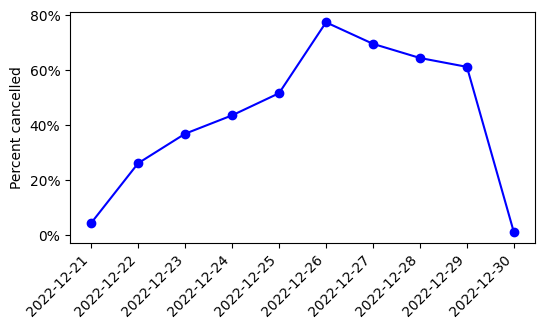

In [17]:
# Plot number of cancellations for each day
dates = []
pct_cancelled = []
for day in tqdm.tqdm(disrupted_dfs):
    dates.append(day["date"].iloc[0])
    pct_cancelled.append(day["cancelled"].mean())

fig, ax = plt.subplots(figsize=(6, 3))
ax.plot(dates, pct_cancelled, "bo-")
ax.set_ylabel("Percent cancelled")
ax.set_xticks(ax.get_xticks())
ax.set_xticklabels(ax.get_xticklabels(), rotation=45, ha='right')
# Mark y axis as percentage
vals = ax.get_yticks()
ax.set_yticklabels(['{:,.0%}'.format(x) for x in vals]);

In [ ]:
pct_cancelled

[0.2159090909090909,
 0.6022727272727273,
 0.5,
 0.4305555555555556,
 0.5102040816326531,
 0.7727272727272727,
 0.25,
 0.23863636363636365,
 0.22727272727272727,
 0.0]

In [ ]:
df.origin_airport.unique()

array(['DAL', 'DEN', 'MDW', 'LAS'], dtype=object)